# Imports

In [1]:
import random
import math
import copy
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
NUM_ITER = 1000
NUM_SIM = 200

# Define Tic Tac Toe Game and Agents

## Tic Tac Toe

In [3]:
class TicTacToe:
    def __init__(self):
        self.board = [" "] * 9
        self.current_player = "X"

    def available_actions(self):
        return [i for i, spot in enumerate(self.board) if spot == " "]

    def play_move(self, action):
        if self.board[action] != " ":
            raise ValueError("Invalid move")
        self.board[action] = self.current_player
        self.current_player = "O" if self.current_player == "X" else "X"

    def winner(self):
        lines = [
            (0, 1, 2),
            (3, 4, 5),
            (6, 7, 8),
            (0, 3, 6),
            (1, 4, 7),
            (2, 5, 8),
            (0, 4, 8),
            (2, 4, 6),
        ]
        for i, j, k in lines:
            if self.board[i] == self.board[j] == self.board[k] != " ":
                return self.board[i]
        return None

    def is_terminal(self):
        return self.winner() is not None or all(s != " " for s in self.board)

    def clone(self):
        clone = TicTacToe()
        clone.board = self.board[:]
        clone.current_player = self.current_player
        return clone

## Monte Carlo Agent

In [4]:
def random_agent(game):
    return random.choice(game.available_actions())

In [5]:
def monte_carlo_agent(game, simulations_per_action=NUM_SIM):
    actions = game.available_actions()
    action_wins = defaultdict(int)

    for action in actions:
        for _ in range(simulations_per_action):
            sim_game = game.clone()
            sim_game.play_move(action)

            # Simulate random playout
            while not sim_game.is_terminal():
                sim_game.play_move(random_agent(sim_game))

            winner = sim_game.winner()
            if winner == game.current_player:
                action_wins[action] += 1
            elif winner is None:
                action_wins[action] += 0.5  # Count draw as half-win

    best_action = max(actions, key=lambda a: action_wins[a])
    return best_action

## MCTS Agent

In [6]:
class MCTSNode:
    def __init__(self, game, parent=None):
        self.game = game
        self.parent = parent
        self.children = {}
        self.wins = 0
        self.visits = 0
        self.untried_actions = game.available_actions()

    def ucb1(self, total_simulations, c=1.41):
        if self.visits == 0:
            return float("inf")
        return self.wins / self.visits + c * math.sqrt(
            math.log(total_simulations) / self.visits
        )

    def best_child(self):
        return max(self.children.values(), key=lambda node: node.ucb1(self.visits))

    def expand(self):
        action = self.untried_actions.pop()
        next_game = self.game.clone()
        next_game.play_move(action)
        child_node = MCTSNode(next_game, parent=self)
        self.children[action] = child_node
        return child_node

    def backpropagate(self, result):
        self.visits += 1
        if result == self.game.current_player:  # Last move was opponent
            self.wins += 0
        elif result is not None:
            self.wins += 1
        if self.parent:
            self.parent.backpropagate(result)

    def is_fully_expanded(self):
        return len(self.untried_actions) == 0

In [7]:
def mcts(root_game, iter_limit=NUM_ITER):
    root_node = MCTSNode(root_game)
    for _ in range(iter_limit):
        node = root_node
        while not node.game.is_terminal() and node.is_fully_expanded():
            node = node.best_child()

        if not node.game.is_terminal():
            node = node.expand()

        game_result = node.game.winner()
        node.backpropagate(game_result)

    best_action = max(root_node.children.items(), key=lambda item: item[1].visits)[0]
    return best_action

In [8]:
def mcts_agent(game, iterations=NUM_ITER):
    return mcts(game, iter_limit=iterations)

# Play Games and Compare results

## Definitions

In [9]:
def play_game(agent_X, agent_O, verbose=False):
    game = TicTacToe()
    while not game.is_terminal():
        if game.current_player == "X":
            action = agent_X(game.clone())
        else:
            action = agent_O(game.clone())
        game.play_move(action)
        if verbose:
            print(game.board[0:3])
            print(game.board[3:6])
            print(game.board[6:9])
            print()
    return game.winner()

In [10]:
def display_results(results, agent_X, agent_O):
    labels = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color=["green", "red", "gray"])
    plt.title(f"{agent_X} (X) vs {agent_O} (O)")
    plt.ylabel("Games Won")
    plt.show()

## 2 simulations: Each agent begins in one of them

### MC Agent vs Random Agent

In [11]:
results_mc_random = {"X": 0, "O": 0, "Draw": 0}

for _ in range(NUM_ITER):
    result = play_game(monte_carlo_agent, random_agent)
    if result == "X":
        results_mc_random["X"] += 1
    elif result == "O":
        results_mc_random["O"] += 1
    else:
        results_mc_random["Draw"] += 1

print("MC (X) vs Random (O):", results_mc_random)

MC (X) vs Random (O): {'X': 986, 'O': 0, 'Draw': 14}


In [12]:
results_random_mc = {"X": 0, "O": 0, "Draw": 0}

for _ in range(NUM_ITER):
    result = play_game(random_agent, monte_carlo_agent)
    if result == "X":
        results_random_mc["X"] += 1
    elif result == "O":
        results_random_mc["O"] += 1
    else:
        results_random_mc["Draw"] += 1

print("Random (X) vs MC (O):", results_random_mc)

Random (X) vs MC (O): {'X': 28, 'O': 908, 'Draw': 64}


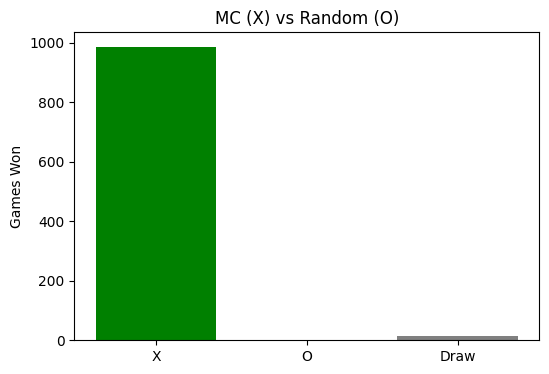

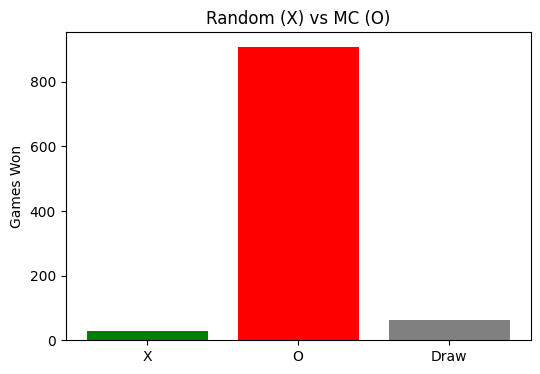

In [13]:
display_results(results_mc_random, "MC", "Random")
display_results(results_random_mc, "Random", "MC")

## MCTS Agent vs. Random Agent

In [14]:
results_mcts_random = {"X": 0, "O": 0, "Draw": 0}

for _ in range(NUM_ITER):
    result = play_game(mcts_agent, random_agent)
    if result == "X":
        results_mcts_random["X"] += 1
    elif result == "O":
        results_mcts_random["O"] += 1
    else:
        results_mcts_random["Draw"] += 1

print("MCTS (X) vs Random (O):", results_mcts_random)

MCTS (X) vs Random (O): {'X': 992, 'O': 0, 'Draw': 8}


In [15]:
results_random_mcts = {"X": 0, "O": 0, "Draw": 0}

for _ in range(NUM_ITER):
    result = play_game(random_agent, mcts_agent)
    if result == "X":
        results_random_mcts["X"] += 1
    elif result == "O":
        results_random_mcts["O"] += 1
    else:
        results_random_mcts["Draw"] += 1

print("Random (X) vs MCTS (O):", results_random_mcts)

Random (X) vs MCTS (O): {'X': 88, 'O': 880, 'Draw': 32}


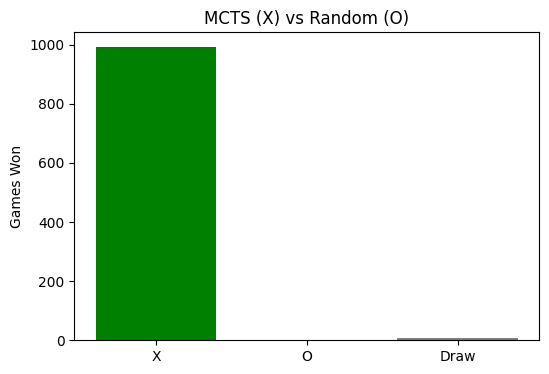

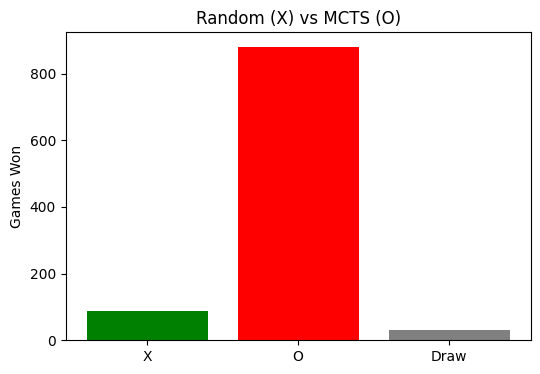

In [16]:
display_results(results_mcts_random, "MCTS", "Random")
display_results(results_random_mcts, "Random", "MCTS")

## MCTS Agent vs. MC Agent

In [ ]:
results_mcts_mc = {"X": 0, "O": 0, "Draw": 0}

for _ in range(NUM_ITER):
    result = play_game(mcts_agent, monte_carlo_agent)
    if result == "X":
        results_mcts_mc["X"] += 1
    elif result == "O":
        results_mcts_mc["O"] += 1
    else:
        results_mcts_mc["Draw"] += 1

print("MCTS (X) vs MC (O):", results_mcts_mc)

In [ ]:
results_mc_mcts = {"X": 0, "O": 0, "Draw": 0}

for _ in range(NUM_ITER):
    result = play_game(monte_carlo_agent, mcts_agent)
    if result == "X":
        results_mc_mcts["X"] += 1
    elif result == "O":
        results_mc_mcts["O"] += 1
    else:
        results_mc_mcts["Draw"] += 1

print("MC (X) vs MCTS (O):", results_mc_mcts)

In [ ]:
display_results(results_mcts_mc, "MCTS", "MC")
display_results(results_mc_mcts, "MC", "MCTS")

### MCTS vs MCTS

In [ ]:
results_mcts_mcts = {"X": 0, "O": 0, "Draw": 0}

for _ in range(NUM_ITER):
    result = play_game(mcts_agent, mcts_agent)
    if result == "X":
        results_mcts_mcts["X"] += 1
    elif result == "O":
        results_mcts_mcts["O"] += 1
    else:
        results_mcts_mcts["Draw"] += 1

print("MCTS_1 (X) vs MCTS_2 (O):", results_mcts_mcts)

In [ ]:
display_results(results_mcts_mcts, "MCTS_1", "MCTS_2")

### MC vs MC

In [ ]:
results_mc_mc = {"X": 0, "O": 0, "Draw": 0}

for _ in range(NUM_ITER):
    result = play_game(monte_carlo_agent, monte_carlo_agent)
    if result == "X":
        results_mc_mc["X"] += 1
    elif result == "O":
        results_mc_mc["O"] += 1
    else:
        results_mc_mc["Draw"] += 1

print("MC_1 (X) vs MC_2 (O):", results_mc_mc)

In [ ]:
display_results(results_mc_mc, "MC_1", "MC_2")

### Random vs Random

In [ ]:
results_random_random = {"X": 0, "O": 0, "Draw": 0}

for _ in range(NUM_ITER * 1000):
    result = play_game(random_agent, random_agent)
    if result == "X":
        results_random_random["X"] += 1
    elif result == "O":
        results_random_random["O"] += 1
    else:
        results_random_random["Draw"] += 1

print("Random_1 (X) vs Random_2 (O):", results_random_random)

In [ ]:
display_results(results_random_random, "Random_1", "Random_2")